# Packages

In [1]:
!pip install torchmetrics tqdm --upgrade

# Imports

In [2]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split

from torchmetrics.text import Perplexity

import tqdm

from collections import Counter

2023-10-14 22:21:47.241230: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-14 22:21:48.292123: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Configuration

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
seq_len = 50
batch_size = 25
min_freq = 0

num_epochs = 300

max_lr_dec = 3
lr_dec = 0

# Utils

In [4]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [5]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# Dataset

## Download Dataset

In [6]:
!wget --quiet --continue https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
!unzip -q wikitext-2-v1.zip
!cd wikitext-2 && mv wiki.train.tokens train.txt
!cd wikitext-2 && mv wiki.valid.tokens valid.txt
!cd wikitext-2 && mv wiki.test.tokens test.txt

In [7]:
tokenizer = get_tokenizer("basic_english")

In [8]:
def load_dataset(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        dataset = file.read()
    return dataset

def tokenize_dataset(dataset):
    tokens = []
    for line in dataset.split('\n'):
        line_tokens = tokenizer(line.strip())
        tokens.extend(line_tokens)
    return tokens

train_dataset = load_dataset("./wikitext-2/train.txt")
valid_dataset = load_dataset("./wikitext-2/valid.txt")
test_dataset = load_dataset("./wikitext-2/test.txt")

train_tokens = tokenize_dataset(train_dataset)
valid_tokens = tokenize_dataset(valid_dataset)
test_tokens = tokenize_dataset(test_dataset)

In [9]:

train_dataset = load_dataset("./wikitext-2/train.txt")
valid_dataset = load_dataset("./wikitext-2/valid.txt")
test_dataset = load_dataset("./wikitext-2/test.txt")

train_tokens = tokenize_dataset(train_dataset)
valid_tokens = tokenize_dataset(valid_dataset)
test_tokens = tokenize_dataset(test_dataset)

all_tokens = train_tokens + valid_tokens + test_tokens
print("Train Tokens: " , len(train_tokens))
print("Valid Tokens: " , len(valid_tokens))
print("Test Tokens: " , len(test_tokens))
print("Total number of tokens:", len(all_tokens))

Train Tokens:  2049990
Valid Tokens:  214417
Test Tokens:  241859
Total number of tokens: 2506266


In [10]:
tokenized_datasets = [train_tokens] 

special_tokens = ['<pad>', '<unk>', '<bos>', '<eos>']

vocab = build_vocab_from_iterator(tokenized_datasets, specials=special_tokens , min_freq=min_freq)

vocab.set_default_index(vocab['<unk>'])

vocab_size = len(vocab)
vocab_itos = vocab.get_itos()

torch.save(vocab, f"./train_vocab_moses_{min_freq}.voc")
print("Vocabulary size:", vocab_size)

Vocabulary size: 28785


## Custom Dataset

In [11]:
class Wikitext2Dataset(Dataset):
  def __init__(self, tokens, seq_len):
    self.tokens = tokens
    self.seq_len = seq_len
  def __len__(self):
    return  len(self.tokens) // self.seq_len

  def __getitem__(self, idx):
    start_idx = idx * self.seq_len
    end_idx = start_idx + self.seq_len
    input = self.tokens[start_idx:end_idx]
    target = self.tokens[start_idx+1:end_idx+1]
    return torch.tensor(input), torch.tensor(target)

## Load Dataset

In [12]:
train_tokens_voc = vocab(train_tokens)
valid_tokens_voc = vocab(valid_tokens)
test_tokens_voc = vocab(test_tokens)

# Datasets
train_dataset = Wikitext2Dataset(train_tokens_voc, seq_len)
valid_dataset = Wikitext2Dataset(valid_tokens_voc, seq_len)
test_dataset = Wikitext2Dataset(test_tokens_voc, seq_len)

# Dataloaders
train_loader = DataLoader(train_dataset , batch_size )
valid_loader = DataLoader(valid_dataset , batch_size )
test_loader = DataLoader(test_dataset , batch_size )

# Model

In [13]:
class H_LSTM(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate):
    super().__init__()
    self.vocab_size = vocab_size
    
    #Embedding Layer
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.dropout_em = nn.Dropout(0.1)
    
    # Layer 1
    self.rnn1 = nn.LSTM(input_size=embedding_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout1 = nn.Dropout(dropout_rate)
    
    # Layer 2
    self.rnn2 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout2 = nn.Dropout(dropout_rate)
    
    # Layer 3
    self.rnn3 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=1,
                      bidirectional=False,
                      batch_first=True)
    self.dropout3 = nn.Dropout(dropout_rate)
    
    self.fc = nn.Linear(hidden_dim,vocab_size,bias=True)

  def forward(self, src):
    embedding = self.dropout_em( self.embedding(src) )
    
    output, (h,c) = self.rnn1(embedding)
    output = self.dropout1(output)
    
    output, (h,c) = self.rnn2(output,(c,h))
    output = self.dropout2(output)
    
    output, (h,c) = self.rnn3(output,(c,h))
    output = self.dropout3(output)
    
    output = self.fc(output)
    return output


# Train

## Learning Functions

In [14]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch=1):
  
  global seq_len
  global batch_size
  
  model.train()
  loss_train = AverageMeter()
  perplexity_train = AverageMeter()
    
  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:

      tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)
      
      loss = loss_fn(outputs, targets)
      
      loss.backward()
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))
      
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      perplexity_train.update(perplexity.item(), n=len(targets))

      tepoch.set_postfix(loss=loss_train.avg, perplexity = perplexity_train.avg )
      
      del inputs
      del targets
      del outputs

  return model, loss_train.avg, perplexity_train.avg 

In [15]:
def evaluate(model, test_loader, loss_fn , perp ):
  
  global seq_len
  global batch_size
  
  model.eval()
  loss_eval = AverageMeter()
  perplexity_eval = AverageMeter()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      
      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)

      loss = loss_fn(outputs, targets)
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))

      loss_eval.update(loss.item(), n=len(targets))
      perplexity_eval.update(perplexity.item(), n=len(targets))
      
      del inputs
      del targets
      del outputs

  return loss_eval.avg,perplexity_eval.avg

## Parameters

In [16]:
embedding_dim = 500
hidden_dim = 500
num_layers = 1
dropout_rate = 0.25

model = H_LSTM( vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim , num_layers=num_layers, dropout_rate= dropout_rate )
loss_train_hist = []
loss_valid_hist = []

per_train_hist = []
per_valid_hist = []

lr_train_hist = []

best_perplexity_valid = torch.inf
epoch_counter = 0
print(f"Trainable Parameters: {num_trainable_params(model)}\n")
model = model.to(device)
model

Trainable Parameters: 34.825785



H_LSTM(
  (embedding): Embedding(28785, 500)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(500, 500, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(500, 500, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(500, 500, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=500, out_features=28785, bias=True)
)

## Learning Loop

In [17]:
lr = 0.5
wd = 1e-5
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()  
perp = Perplexity().to(device)

In [18]:
num_epochs = 300
max_lr_dec = 4
lr_dec = 0

for epoch in range(num_epochs):
  # Train
  model, loss_train, per_train = train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch)
  # Validation
  loss_valid, per_val = evaluate(model, valid_loader, loss_fn, perp)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  per_train_hist.append(per_train)
  per_valid_hist.append(per_val)

  lr_train_hist.append(lr)
  
  print(f'Valid: Loss = {loss_valid:.4} Perplexity= {per_val:.4}, LR = {lr}')
  epoch_counter += 1
  
  if per_val < best_perplexity_valid:
    lr_dec = 0
    torch.save(model, f'model.pt')
    best_perplexity_valid = per_val
    print('Model Saved!')
  else:
    if lr_dec >= max_lr_dec :
      print("LR_DEC==3 , Finished")
      break
    lr_dec += 1
    
    del model
    del perp
    del loss_fn
    del optimizer
    
    model_path = 'model.pt'
    model = torch.load(model_path,map_location=device)
    lr /= 2
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
    loss_fn = nn.CrossEntropyLoss()
    perp = Perplexity().to(device)
  print()
  

Epoch 0: 100%|██████████| 1640/1640 [04:28<00:00,  6.10batch/s, loss=6.53, perplexity=966]    


Valid: Loss = 5.843 Perplexity= 352.2, LR = 0.5
Model Saved!



Epoch 1: 100%|██████████| 1640/1640 [04:45<00:00,  5.74batch/s, loss=5.92, perplexity=384]


Valid: Loss = 5.566 Perplexity= 267.6, LR = 0.5
Model Saved!



Epoch 2: 100%|██████████| 1640/1640 [04:52<00:00,  5.61batch/s, loss=5.68, perplexity=302]


Valid: Loss = 5.404 Perplexity= 228.3, LR = 0.5
Model Saved!



Epoch 3: 100%|██████████| 1640/1640 [04:49<00:00,  5.66batch/s, loss=5.51, perplexity=255]


Valid: Loss = 5.297 Perplexity= 205.5, LR = 0.5
Model Saved!



Epoch 4: 100%|██████████| 1640/1640 [04:49<00:00,  5.67batch/s, loss=5.38, perplexity=224]


Valid: Loss = 5.224 Perplexity= 191.5, LR = 0.5
Model Saved!



Epoch 5: 100%|██████████| 1640/1640 [04:50<00:00,  5.65batch/s, loss=5.27, perplexity=201]


Valid: Loss = 5.171 Perplexity= 182.0, LR = 0.5
Model Saved!



Epoch 6: 100%|██████████| 1640/1640 [04:50<00:00,  5.64batch/s, loss=5.17, perplexity=184]


Valid: Loss = 5.12 Perplexity= 173.2, LR = 0.5
Model Saved!



Epoch 7: 100%|██████████| 1640/1640 [04:51<00:00,  5.63batch/s, loss=5.09, perplexity=169]


Valid: Loss = 5.084 Perplexity= 167.6, LR = 0.5
Model Saved!



Epoch 8: 100%|██████████| 1640/1640 [04:51<00:00,  5.62batch/s, loss=5.01, perplexity=157]


Valid: Loss = 5.063 Perplexity= 164.4, LR = 0.5
Model Saved!



Epoch 9: 100%|██████████| 1640/1640 [04:36<00:00,  5.93batch/s, loss=4.94, perplexity=146]


Valid: Loss = 5.031 Perplexity= 159.2, LR = 0.5
Model Saved!



Epoch 10: 100%|██████████| 1640/1640 [04:20<00:00,  6.31batch/s, loss=4.87, perplexity=137]


Valid: Loss = 5.011 Perplexity= 156.3, LR = 0.5
Model Saved!



Epoch 11: 100%|██████████| 1640/1640 [04:20<00:00,  6.30batch/s, loss=4.82, perplexity=129]


Valid: Loss = 5.011 Perplexity= 156.1, LR = 0.5
Model Saved!



Epoch 12: 100%|██████████| 1640/1640 [04:20<00:00,  6.30batch/s, loss=4.76, perplexity=122]


Valid: Loss = 4.985 Perplexity= 152.6, LR = 0.5
Model Saved!



Epoch 13: 100%|██████████| 1640/1640 [04:20<00:00,  6.30batch/s, loss=4.71, perplexity=116]


Valid: Loss = 4.959 Perplexity= 149.1, LR = 0.5
Model Saved!



Epoch 14: 100%|██████████| 1640/1640 [04:20<00:00,  6.29batch/s, loss=4.65, perplexity=110]


Valid: Loss = 4.934 Perplexity= 145.1, LR = 0.5
Model Saved!



Epoch 15: 100%|██████████| 1640/1640 [04:20<00:00,  6.29batch/s, loss=4.6, perplexity=104] 


Valid: Loss = 4.914 Perplexity= 142.4, LR = 0.5
Model Saved!



Epoch 16: 100%|██████████| 1640/1640 [04:20<00:00,  6.29batch/s, loss=4.54, perplexity=98.6]


Valid: Loss = 4.883 Perplexity= 138.3, LR = 0.5
Model Saved!



Epoch 17: 100%|██████████| 1640/1640 [04:20<00:00,  6.29batch/s, loss=4.5, perplexity=94]   


Valid: Loss = 4.867 Perplexity= 136.1, LR = 0.5
Model Saved!



Epoch 18: 100%|██████████| 1640/1640 [04:20<00:00,  6.29batch/s, loss=4.45, perplexity=89.6]


Valid: Loss = 4.828 Perplexity= 130.7, LR = 0.5
Model Saved!



Epoch 19: 100%|██████████| 1640/1640 [04:20<00:00,  6.28batch/s, loss=4.41, perplexity=86.3]


Valid: Loss = 4.802 Perplexity= 127.4, LR = 0.5
Model Saved!



Epoch 20: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=4.37, perplexity=82.6]


Valid: Loss = 4.769 Perplexity= 123.2, LR = 0.5
Model Saved!



Epoch 21: 100%|██████████| 1640/1640 [04:21<00:00,  6.27batch/s, loss=4.33, perplexity=79.4]


Valid: Loss = 4.771 Perplexity= 123.8, LR = 0.5



Epoch 22: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=4.2, perplexity=70.3] 


Valid: Loss = 4.702 Perplexity= 115.9, LR = 0.25
Model Saved!



Epoch 23: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=4.13, perplexity=65.1]


Valid: Loss = 4.662 Perplexity= 111.3, LR = 0.25
Model Saved!



Epoch 24: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=4.09, perplexity=62.3]


Valid: Loss = 4.644 Perplexity= 109.3, LR = 0.25
Model Saved!



Epoch 25: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=4.05, perplexity=60.1]


Valid: Loss = 4.639 Perplexity= 108.8, LR = 0.25
Model Saved!



Epoch 26: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=4.02, perplexity=58.2]


Valid: Loss = 4.612 Perplexity= 105.7, LR = 0.25
Model Saved!



Epoch 27: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.99, perplexity=56.6]


Valid: Loss = 4.588 Perplexity= 103.3, LR = 0.25
Model Saved!



Epoch 28: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.96, perplexity=55]  


Valid: Loss = 4.555 Perplexity= 99.62, LR = 0.25
Model Saved!



Epoch 29: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.94, perplexity=53.5]


Valid: Loss = 4.54 Perplexity= 98.17, LR = 0.25
Model Saved!



Epoch 30: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.91, perplexity=52.3]


Valid: Loss = 4.539 Perplexity= 98.16, LR = 0.25
Model Saved!



Epoch 31: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.89, perplexity=50.9]


Valid: Loss = 4.521 Perplexity= 96.56, LR = 0.25
Model Saved!



Epoch 32: 100%|██████████| 1640/1640 [04:21<00:00,  6.27batch/s, loss=3.86, perplexity=49.5]


Valid: Loss = 4.522 Perplexity= 96.67, LR = 0.25



Epoch 33: 100%|██████████| 1640/1640 [04:20<00:00,  6.29batch/s, loss=3.77, perplexity=45.4]


Valid: Loss = 4.434 Perplexity= 88.57, LR = 0.125
Model Saved!



Epoch 34: 100%|██████████| 1640/1640 [04:20<00:00,  6.29batch/s, loss=3.72, perplexity=43]  


Valid: Loss = 4.405 Perplexity= 86.12, LR = 0.125
Model Saved!



Epoch 35: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.69, perplexity=41.8]


Valid: Loss = 4.397 Perplexity= 85.35, LR = 0.125
Model Saved!



Epoch 36: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.66, perplexity=40.7]


Valid: Loss = 4.371 Perplexity= 83.01, LR = 0.125
Model Saved!



Epoch 37: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.64, perplexity=39.8]


Valid: Loss = 4.354 Perplexity= 81.52, LR = 0.125
Model Saved!



Epoch 38: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.62, perplexity=39]  


Valid: Loss = 4.337 Perplexity= 80.12, LR = 0.125
Model Saved!



Epoch 39: 100%|██████████| 1640/1640 [04:21<00:00,  6.27batch/s, loss=3.6, perplexity=38.3]


Valid: Loss = 4.324 Perplexity= 79.15, LR = 0.125
Model Saved!



Epoch 40: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.59, perplexity=37.6]


Valid: Loss = 4.329 Perplexity= 79.56, LR = 0.125



Epoch 41: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.54, perplexity=35.8]


Valid: Loss = 4.255 Perplexity= 73.78, LR = 0.0625
Model Saved!



Epoch 42: 100%|██████████| 1640/1640 [04:21<00:00,  6.27batch/s, loss=3.5, perplexity=34.5] 


Valid: Loss = 4.229 Perplexity= 71.85, LR = 0.0625
Model Saved!



Epoch 43: 100%|██████████| 1640/1640 [04:21<00:00,  6.27batch/s, loss=3.48, perplexity=33.8]


Valid: Loss = 4.22 Perplexity= 71.23, LR = 0.0625
Model Saved!



Epoch 44: 100%|██████████| 1640/1640 [04:21<00:00,  6.27batch/s, loss=3.46, perplexity=33.2]


Valid: Loss = 4.202 Perplexity= 69.98, LR = 0.0625
Model Saved!



Epoch 45: 100%|██████████| 1640/1640 [04:21<00:00,  6.27batch/s, loss=3.45, perplexity=32.7]


Valid: Loss = 4.191 Perplexity= 69.22, LR = 0.0625
Model Saved!



Epoch 46: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.43, perplexity=32.2]


Valid: Loss = 4.18 Perplexity= 68.43, LR = 0.0625
Model Saved!



Epoch 47: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.42, perplexity=31.7]


Valid: Loss = 4.168 Perplexity= 67.57, LR = 0.0625
Model Saved!



Epoch 48: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.4, perplexity=31.3] 


Valid: Loss = 4.169 Perplexity= 67.68, LR = 0.0625



Epoch 49: 100%|██████████| 1640/1640 [04:21<00:00,  6.27batch/s, loss=3.38, perplexity=30.6]


Valid: Loss = 4.135 Perplexity= 65.4, LR = 0.03125
Model Saved!



Epoch 50: 100%|██████████| 1640/1640 [04:21<00:00,  6.27batch/s, loss=3.36, perplexity=30]  


Valid: Loss = 4.122 Perplexity= 64.57, LR = 0.03125
Model Saved!



Epoch 51: 100%|██████████| 1640/1640 [04:21<00:00,  6.27batch/s, loss=3.35, perplexity=29.6]


Valid: Loss = 4.109 Perplexity= 63.76, LR = 0.03125
Model Saved!



Epoch 52: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.34, perplexity=29.2]


Valid: Loss = 4.121 Perplexity= 64.53, LR = 0.03125



Epoch 53: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.34, perplexity=29.4]


Valid: Loss = 4.075 Perplexity= 61.56, LR = 0.015625
Model Saved!



Epoch 54: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.33, perplexity=29.1]


Valid: Loss = 4.06 Perplexity= 60.6, LR = 0.015625
Model Saved!



Epoch 55: 100%|██████████| 1640/1640 [04:21<00:00,  6.27batch/s, loss=3.32, perplexity=28.8]


Valid: Loss = 4.052 Perplexity= 60.17, LR = 0.015625
Model Saved!



Epoch 56: 100%|██████████| 1640/1640 [04:43<00:00,  5.79batch/s, loss=3.31, perplexity=28.4]


Valid: Loss = 4.036 Perplexity= 59.22, LR = 0.015625
Model Saved!



Epoch 57: 100%|██████████| 1640/1640 [04:56<00:00,  5.54batch/s, loss=3.3, perplexity=28.2] 


Valid: Loss = 4.03 Perplexity= 58.81, LR = 0.015625
Model Saved!



Epoch 58: 100%|██████████| 1640/1640 [04:43<00:00,  5.79batch/s, loss=3.29, perplexity=27.9]


Valid: Loss = 4.025 Perplexity= 58.53, LR = 0.015625
Model Saved!



Epoch 59: 100%|██████████| 1640/1640 [04:43<00:00,  5.79batch/s, loss=3.28, perplexity=27.7]


Valid: Loss = 4.023 Perplexity= 58.39, LR = 0.015625
Model Saved!



Epoch 60: 100%|██████████| 1640/1640 [04:48<00:00,  5.69batch/s, loss=3.27, perplexity=27.4]


Valid: Loss = 4.011 Perplexity= 57.66, LR = 0.015625
Model Saved!



Epoch 61: 100%|██████████| 1640/1640 [04:47<00:00,  5.70batch/s, loss=3.27, perplexity=27.2]


Valid: Loss = 4.006 Perplexity= 57.42, LR = 0.015625
Model Saved!



Epoch 62: 100%|██████████| 1640/1640 [04:49<00:00,  5.67batch/s, loss=3.26, perplexity=27]  


Valid: Loss = 4.006 Perplexity= 57.44, LR = 0.015625



Epoch 63: 100%|██████████| 1640/1640 [04:52<00:00,  5.60batch/s, loss=3.26, perplexity=27.1]


Valid: Loss = 3.966 Perplexity= 55.11, LR = 0.0078125
Model Saved!



Epoch 64: 100%|██████████| 1640/1640 [04:54<00:00,  5.57batch/s, loss=3.25, perplexity=26.8]


Valid: Loss = 3.964 Perplexity= 55.02, LR = 0.0078125
Model Saved!



Epoch 65: 100%|██████████| 1640/1640 [04:58<00:00,  5.49batch/s, loss=3.25, perplexity=26.7]


Valid: Loss = 3.956 Perplexity= 54.57, LR = 0.0078125
Model Saved!



Epoch 66: 100%|██████████| 1640/1640 [04:54<00:00,  5.58batch/s, loss=3.24, perplexity=26.6]


Valid: Loss = 3.952 Perplexity= 54.37, LR = 0.0078125
Model Saved!



Epoch 67: 100%|██████████| 1640/1640 [04:53<00:00,  5.58batch/s, loss=3.24, perplexity=26.4]


Valid: Loss = 3.95 Perplexity= 54.22, LR = 0.0078125
Model Saved!



Epoch 68: 100%|██████████| 1640/1640 [04:53<00:00,  5.59batch/s, loss=3.23, perplexity=26.3]


Valid: Loss = 3.945 Perplexity= 53.96, LR = 0.0078125
Model Saved!



Epoch 69: 100%|██████████| 1640/1640 [04:53<00:00,  5.59batch/s, loss=3.23, perplexity=26.2]


Valid: Loss = 3.941 Perplexity= 53.72, LR = 0.0078125
Model Saved!



Epoch 70: 100%|██████████| 1640/1640 [04:52<00:00,  5.61batch/s, loss=3.22, perplexity=26.1]


Valid: Loss = 3.934 Perplexity= 53.36, LR = 0.0078125
Model Saved!



Epoch 71: 100%|██████████| 1640/1640 [04:43<00:00,  5.78batch/s, loss=3.22, perplexity=26]  


Valid: Loss = 3.931 Perplexity= 53.19, LR = 0.0078125
Model Saved!



Epoch 72: 100%|██████████| 1640/1640 [04:21<00:00,  6.26batch/s, loss=3.22, perplexity=25.9]


Valid: Loss = 3.932 Perplexity= 53.24, LR = 0.0078125



Epoch 73: 100%|██████████| 1640/1640 [04:21<00:00,  6.27batch/s, loss=3.22, perplexity=26]  


Valid: Loss = 3.904 Perplexity= 51.72, LR = 0.00390625
Model Saved!



Epoch 74: 100%|██████████| 1640/1640 [04:21<00:00,  6.27batch/s, loss=3.22, perplexity=26]  


Valid: Loss = 3.902 Perplexity= 51.61, LR = 0.00390625
Model Saved!



Epoch 75: 100%|██████████| 1640/1640 [04:21<00:00,  6.27batch/s, loss=3.22, perplexity=26]  


Valid: Loss = 3.894 Perplexity= 51.23, LR = 0.00390625
Model Saved!



Epoch 76: 100%|██████████| 1640/1640 [04:29<00:00,  6.09batch/s, loss=3.22, perplexity=25.9]


Valid: Loss = 3.892 Perplexity= 51.11, LR = 0.00390625
Model Saved!



Epoch 77: 100%|██████████| 1640/1640 [04:48<00:00,  5.68batch/s, loss=3.21, perplexity=25.8]


Valid: Loss = 3.89 Perplexity= 51.02, LR = 0.00390625
Model Saved!



Epoch 78: 100%|██████████| 1640/1640 [05:03<00:00,  5.40batch/s, loss=3.21, perplexity=25.7]


Valid: Loss = 3.887 Perplexity= 50.86, LR = 0.00390625
Model Saved!



Epoch 79: 100%|██████████| 1640/1640 [04:59<00:00,  5.47batch/s, loss=3.21, perplexity=25.6]


Valid: Loss = 3.887 Perplexity= 50.86, LR = 0.00390625
Model Saved!



Epoch 80: 100%|██████████| 1640/1640 [04:59<00:00,  5.47batch/s, loss=3.2, perplexity=25.6] 


Valid: Loss = 3.883 Perplexity= 50.63, LR = 0.00390625
Model Saved!



Epoch 81: 100%|██████████| 1640/1640 [04:58<00:00,  5.49batch/s, loss=3.2, perplexity=25.5] 


Valid: Loss = 3.88 Perplexity= 50.49, LR = 0.00390625
Model Saved!



Epoch 82: 100%|██████████| 1640/1640 [05:00<00:00,  5.46batch/s, loss=3.2, perplexity=25.4] 


Valid: Loss = 3.877 Perplexity= 50.34, LR = 0.00390625
Model Saved!



Epoch 83: 100%|██████████| 1640/1640 [05:02<00:00,  5.43batch/s, loss=3.19, perplexity=25.4]


Valid: Loss = 3.874 Perplexity= 50.19, LR = 0.00390625
Model Saved!



Epoch 84: 100%|██████████| 1640/1640 [05:02<00:00,  5.43batch/s, loss=3.19, perplexity=25.3]


Valid: Loss = 3.871 Perplexity= 50.04, LR = 0.00390625
Model Saved!



Epoch 85: 100%|██████████| 1640/1640 [04:54<00:00,  5.57batch/s, loss=3.19, perplexity=25.3]


Valid: Loss = 3.87 Perplexity= 49.98, LR = 0.00390625
Model Saved!



Epoch 86: 100%|██████████| 1640/1640 [04:54<00:00,  5.57batch/s, loss=3.19, perplexity=25.2]


Valid: Loss = 3.867 Perplexity= 49.82, LR = 0.00390625
Model Saved!



Epoch 87: 100%|██████████| 1640/1640 [05:01<00:00,  5.44batch/s, loss=3.19, perplexity=25.1]


Valid: Loss = 3.863 Perplexity= 49.66, LR = 0.00390625
Model Saved!



Epoch 88: 100%|██████████| 1640/1640 [04:41<00:00,  5.83batch/s, loss=3.18, perplexity=25.1]


Valid: Loss = 3.863 Perplexity= 49.62, LR = 0.00390625
Model Saved!



Epoch 89: 100%|██████████| 1640/1640 [04:50<00:00,  5.65batch/s, loss=3.18, perplexity=25]  


Valid: Loss = 3.859 Perplexity= 49.41, LR = 0.00390625
Model Saved!



Epoch 90: 100%|██████████| 1640/1640 [04:47<00:00,  5.70batch/s, loss=3.18, perplexity=24.9]


Valid: Loss = 3.856 Perplexity= 49.32, LR = 0.00390625
Model Saved!



Epoch 91: 100%|██████████| 1640/1640 [04:55<00:00,  5.55batch/s, loss=3.18, perplexity=24.9]


Valid: Loss = 3.858 Perplexity= 49.37, LR = 0.00390625



Epoch 92: 100%|██████████| 1640/1640 [04:55<00:00,  5.55batch/s, loss=3.18, perplexity=24.9]


Valid: Loss = 3.841 Perplexity= 48.52, LR = 0.001953125
Model Saved!



Epoch 93: 100%|██████████| 1640/1640 [04:54<00:00,  5.57batch/s, loss=3.17, perplexity=24.8]


Valid: Loss = 3.838 Perplexity= 48.4, LR = 0.001953125
Model Saved!



Epoch 94: 100%|██████████| 1640/1640 [04:54<00:00,  5.57batch/s, loss=3.17, perplexity=24.8]


Valid: Loss = 3.839 Perplexity= 48.44, LR = 0.001953125



Epoch 95: 100%|██████████| 1640/1640 [04:54<00:00,  5.57batch/s, loss=3.17, perplexity=24.8]


Valid: Loss = 3.833 Perplexity= 48.13, LR = 0.0009765625
Model Saved!



Epoch 96: 100%|██████████| 1640/1640 [04:42<00:00,  5.81batch/s, loss=3.17, perplexity=24.7]


Valid: Loss = 3.831 Perplexity= 48.03, LR = 0.0009765625
Model Saved!



Epoch 97: 100%|██████████| 1640/1640 [04:21<00:00,  6.26batch/s, loss=3.17, perplexity=24.7]


Valid: Loss = 3.83 Perplexity= 48.01, LR = 0.0009765625
Model Saved!



Epoch 98: 100%|██████████| 1640/1640 [04:21<00:00,  6.26batch/s, loss=3.17, perplexity=24.6]


Valid: Loss = 3.829 Perplexity= 47.95, LR = 0.0009765625
Model Saved!



Epoch 99: 100%|██████████| 1640/1640 [04:21<00:00,  6.27batch/s, loss=3.16, perplexity=24.6]


Valid: Loss = 3.827 Perplexity= 47.88, LR = 0.0009765625
Model Saved!



Epoch 100: 100%|██████████| 1640/1640 [04:21<00:00,  6.27batch/s, loss=3.16, perplexity=24.6]


Valid: Loss = 3.827 Perplexity= 47.84, LR = 0.0009765625
Model Saved!



Epoch 101: 100%|██████████| 1640/1640 [04:21<00:00,  6.27batch/s, loss=3.16, perplexity=24.6]


Valid: Loss = 3.825 Perplexity= 47.76, LR = 0.0009765625
Model Saved!



Epoch 102: 100%|██████████| 1640/1640 [04:21<00:00,  6.27batch/s, loss=3.16, perplexity=24.5]


Valid: Loss = 3.826 Perplexity= 47.81, LR = 0.0009765625



Epoch 103: 100%|██████████| 1640/1640 [04:21<00:00,  6.27batch/s, loss=3.16, perplexity=24.5]


Valid: Loss = 3.822 Perplexity= 47.63, LR = 0.00048828125
Model Saved!



Epoch 104: 100%|██████████| 1640/1640 [04:21<00:00,  6.27batch/s, loss=3.16, perplexity=24.5]


Valid: Loss = 3.822 Perplexity= 47.6, LR = 0.00048828125
Model Saved!



Epoch 105: 100%|██████████| 1640/1640 [04:21<00:00,  6.27batch/s, loss=3.16, perplexity=24.5]


Valid: Loss = 3.821 Perplexity= 47.56, LR = 0.00048828125
Model Saved!



Epoch 106: 100%|██████████| 1640/1640 [04:21<00:00,  6.27batch/s, loss=3.16, perplexity=24.5]


Valid: Loss = 3.821 Perplexity= 47.55, LR = 0.00048828125
Model Saved!



Epoch 107: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.16, perplexity=24.5]


Valid: Loss = 3.82 Perplexity= 47.52, LR = 0.00048828125
Model Saved!



Epoch 108: 100%|██████████| 1640/1640 [04:21<00:00,  6.27batch/s, loss=3.16, perplexity=24.4]


Valid: Loss = 3.82 Perplexity= 47.52, LR = 0.00048828125



Epoch 109: 100%|██████████| 1640/1640 [04:21<00:00,  6.27batch/s, loss=3.16, perplexity=24.5]


Valid: Loss = 3.818 Perplexity= 47.45, LR = 0.000244140625
Model Saved!



Epoch 110: 100%|██████████| 1640/1640 [04:21<00:00,  6.27batch/s, loss=3.16, perplexity=24.4]


Valid: Loss = 3.818 Perplexity= 47.43, LR = 0.000244140625
Model Saved!



Epoch 111: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.16, perplexity=24.4]


Valid: Loss = 3.818 Perplexity= 47.42, LR = 0.000244140625
Model Saved!



Epoch 112: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.16, perplexity=24.4]


Valid: Loss = 3.818 Perplexity= 47.41, LR = 0.000244140625
Model Saved!



Epoch 113: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.16, perplexity=24.4]


Valid: Loss = 3.817 Perplexity= 47.39, LR = 0.000244140625
Model Saved!



Epoch 114: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.16, perplexity=24.4]


Valid: Loss = 3.817 Perplexity= 47.38, LR = 0.000244140625
Model Saved!



Epoch 115: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.16, perplexity=24.4]


Valid: Loss = 3.817 Perplexity= 47.36, LR = 0.000244140625
Model Saved!



Epoch 116: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.16, perplexity=24.4]


Valid: Loss = 3.817 Perplexity= 47.37, LR = 0.000244140625



Epoch 117: 100%|██████████| 1640/1640 [04:20<00:00,  6.28batch/s, loss=3.16, perplexity=24.4]


Valid: Loss = 3.816 Perplexity= 47.32, LR = 0.0001220703125
Model Saved!



Epoch 118: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.16, perplexity=24.4]


Valid: Loss = 3.816 Perplexity= 47.31, LR = 0.0001220703125
Model Saved!



Epoch 119: 100%|██████████| 1640/1640 [04:20<00:00,  6.28batch/s, loss=3.15, perplexity=24.4]


Valid: Loss = 3.815 Perplexity= 47.29, LR = 0.0001220703125
Model Saved!



Epoch 120: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.16, perplexity=24.4]


Valid: Loss = 3.815 Perplexity= 47.29, LR = 0.0001220703125
Model Saved!



Epoch 121: 100%|██████████| 1640/1640 [04:20<00:00,  6.29batch/s, loss=3.16, perplexity=24.4]


Valid: Loss = 3.815 Perplexity= 47.27, LR = 0.0001220703125
Model Saved!



Epoch 122: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.15, perplexity=24.3]


Valid: Loss = 3.815 Perplexity= 47.28, LR = 0.0001220703125



Epoch 123: 100%|██████████| 1640/1640 [04:20<00:00,  6.29batch/s, loss=3.16, perplexity=24.4]


Valid: Loss = 3.814 Perplexity= 47.24, LR = 6.103515625e-05
Model Saved!



Epoch 124: 100%|██████████| 1640/1640 [04:20<00:00,  6.29batch/s, loss=3.15, perplexity=24.3]


Valid: Loss = 3.814 Perplexity= 47.23, LR = 6.103515625e-05
Model Saved!



Epoch 125: 100%|██████████| 1640/1640 [04:20<00:00,  6.28batch/s, loss=3.15, perplexity=24.4]


Valid: Loss = 3.814 Perplexity= 47.24, LR = 6.103515625e-05



Epoch 126: 100%|██████████| 1640/1640 [04:20<00:00,  6.29batch/s, loss=3.16, perplexity=24.4]


Valid: Loss = 3.814 Perplexity= 47.22, LR = 3.0517578125e-05
Model Saved!



Epoch 127: 100%|██████████| 1640/1640 [04:20<00:00,  6.29batch/s, loss=3.15, perplexity=24.3]


Valid: Loss = 3.813 Perplexity= 47.22, LR = 3.0517578125e-05
Model Saved!



Epoch 128: 100%|██████████| 1640/1640 [04:20<00:00,  6.29batch/s, loss=3.16, perplexity=24.4]


Valid: Loss = 3.813 Perplexity= 47.21, LR = 3.0517578125e-05
Model Saved!



Epoch 129: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.16, perplexity=24.4]


Valid: Loss = 3.813 Perplexity= 47.21, LR = 3.0517578125e-05
Model Saved!



Epoch 130: 100%|██████████| 1640/1640 [04:20<00:00,  6.29batch/s, loss=3.15, perplexity=24.4]


Valid: Loss = 3.813 Perplexity= 47.21, LR = 3.0517578125e-05
Model Saved!



Epoch 131: 100%|██████████| 1640/1640 [04:20<00:00,  6.29batch/s, loss=3.16, perplexity=24.4]


Valid: Loss = 3.813 Perplexity= 47.2, LR = 3.0517578125e-05
Model Saved!



Epoch 132: 100%|██████████| 1640/1640 [04:20<00:00,  6.29batch/s, loss=3.15, perplexity=24.3]


Valid: Loss = 3.813 Perplexity= 47.2, LR = 3.0517578125e-05



Epoch 133: 100%|██████████| 1640/1640 [04:20<00:00,  6.29batch/s, loss=3.15, perplexity=24.3]


Valid: Loss = 3.813 Perplexity= 47.2, LR = 1.52587890625e-05
Model Saved!



Epoch 134: 100%|██████████| 1640/1640 [04:20<00:00,  6.29batch/s, loss=3.15, perplexity=24.4]


Valid: Loss = 3.813 Perplexity= 47.2, LR = 1.52587890625e-05
Model Saved!



Epoch 135: 100%|██████████| 1640/1640 [04:20<00:00,  6.29batch/s, loss=3.16, perplexity=24.4]


Valid: Loss = 3.813 Perplexity= 47.2, LR = 1.52587890625e-05
Model Saved!



Epoch 136: 100%|██████████| 1640/1640 [04:20<00:00,  6.29batch/s, loss=3.16, perplexity=24.4]


Valid: Loss = 3.813 Perplexity= 47.19, LR = 1.52587890625e-05
Model Saved!



Epoch 137: 100%|██████████| 1640/1640 [04:20<00:00,  6.29batch/s, loss=3.15, perplexity=24.4]


Valid: Loss = 3.813 Perplexity= 47.19, LR = 1.52587890625e-05



Epoch 138: 100%|██████████| 1640/1640 [04:20<00:00,  6.29batch/s, loss=3.15, perplexity=24.4]


Valid: Loss = 3.813 Perplexity= 47.19, LR = 7.62939453125e-06
Model Saved!



Epoch 139: 100%|██████████| 1640/1640 [04:20<00:00,  6.28batch/s, loss=3.15, perplexity=24.3]


Valid: Loss = 3.813 Perplexity= 47.19, LR = 7.62939453125e-06



Epoch 140: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.15, perplexity=24.3]


Valid: Loss = 3.813 Perplexity= 47.19, LR = 3.814697265625e-06



Epoch 141: 100%|██████████| 1640/1640 [04:20<00:00,  6.28batch/s, loss=3.15, perplexity=24.3]


Valid: Loss = 3.813 Perplexity= 47.19, LR = 1.9073486328125e-06
Model Saved!



Epoch 142: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.15, perplexity=24.3]


Valid: Loss = 3.813 Perplexity= 47.19, LR = 1.9073486328125e-06
Model Saved!



Epoch 143: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.15, perplexity=24.3]


Valid: Loss = 3.813 Perplexity= 47.19, LR = 1.9073486328125e-06



Epoch 144: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.15, perplexity=24.3]


Valid: Loss = 3.813 Perplexity= 47.19, LR = 9.5367431640625e-07
Model Saved!



Epoch 145: 100%|██████████| 1640/1640 [04:21<00:00,  6.27batch/s, loss=3.15, perplexity=24.3]


Valid: Loss = 3.813 Perplexity= 47.19, LR = 9.5367431640625e-07
Model Saved!



Epoch 146: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.16, perplexity=24.4]


Valid: Loss = 3.813 Perplexity= 47.19, LR = 9.5367431640625e-07
Model Saved!



Epoch 147: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.15, perplexity=24.3]


Valid: Loss = 3.813 Perplexity= 47.19, LR = 9.5367431640625e-07
Model Saved!



Epoch 148: 100%|██████████| 1640/1640 [04:21<00:00,  6.27batch/s, loss=3.15, perplexity=24.4]


Valid: Loss = 3.813 Perplexity= 47.19, LR = 9.5367431640625e-07



Epoch 149: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.15, perplexity=24.3]


Valid: Loss = 3.813 Perplexity= 47.19, LR = 4.76837158203125e-07
Model Saved!



Epoch 150: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.15, perplexity=24.3]


Valid: Loss = 3.813 Perplexity= 47.19, LR = 4.76837158203125e-07



Epoch 151: 100%|██████████| 1640/1640 [04:21<00:00,  6.28batch/s, loss=3.15, perplexity=24.3]


Valid: Loss = 3.813 Perplexity= 47.19, LR = 2.384185791015625e-07



Epoch 152:  99%|█████████▊| 1616/1640 [04:23<00:03,  6.14batch/s, loss=3.15, perplexity=24.3]


KeyboardInterrupt: 

## Learning Curve

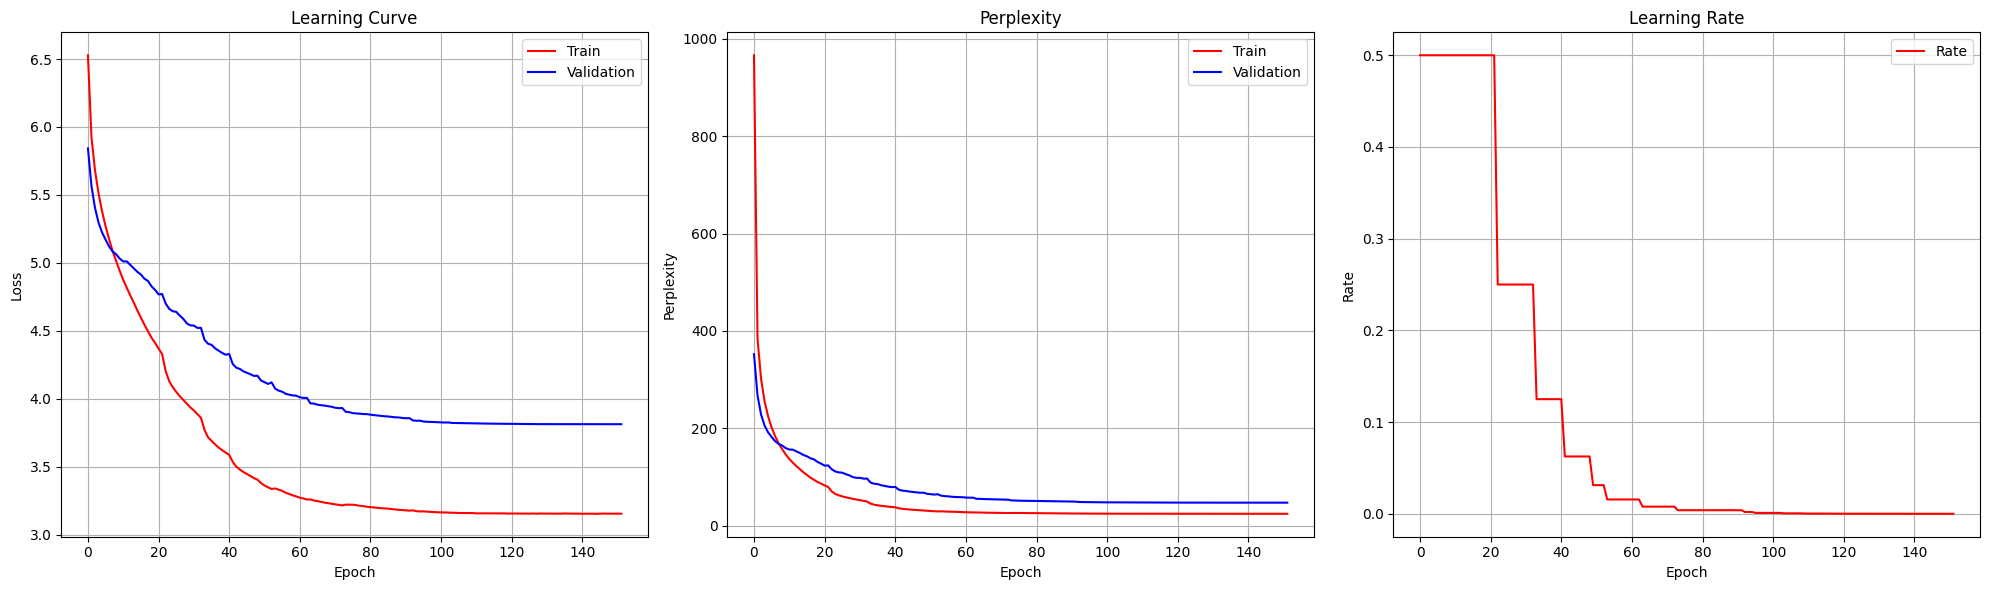

In [19]:
# Save as CSV
import pandas as pd
datas = {
    'epoch': range(epoch_counter),
    'loss_train': loss_train_hist,
    'loss_validation': loss_valid_hist,
    'perplexity_train': per_train_hist , 
    'perplexity_validation':per_valid_hist,
    'learning_rate': lr_train_hist
}
df = pd.DataFrame(datas)
df.to_csv("learningCurve.csv" , index=False)

fig, (ax1, ax2 , ax3) = plt.subplots(1, 3, figsize=(20, 6))

ax1.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
ax1.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')
ax1.set_title('Learning Curve')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

ax2.plot(range(epoch_counter), per_train_hist, 'r-', label='Train')
ax2.plot(range(epoch_counter), per_valid_hist, 'b-', label='Validation')
ax2.set_title('Perplexity')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Perplexity')
ax2.grid(True)
ax2.legend()

ax3.plot(range(epoch_counter), lr_train_hist, 'r-', label='Rate')
ax3.set_title('Learning Rate')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Rate')
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()

## Test Perplexity

In [20]:
model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()

loss_fn = nn.CrossEntropyLoss()
perp = Perplexity().to(device)

loss_valid , per_valid  = evaluate(model, valid_loader, loss_fn , perp )
print(f"Validation: Loss = {loss_valid:.4} , Perplexity = {per_valid:.4}")

loss_test , per_test  = evaluate(model, test_loader, loss_fn , perp)
print(f"Test: Loss = {loss_test:.4} , Perplexity = {per_test:.4}")

Validation: Loss = 3.813 , Perplexity = 47.19
Test: Loss = 3.758 , Perplexity = 45.49


# Text Generation

In [21]:
loss_fn = nn.CrossEntropyLoss()

model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()
model

H_LSTM(
  (embedding): Embedding(28785, 500)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(500, 500, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(500, 500, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(500, 500, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=500, out_features=28785, bias=True)
)

In [22]:
num_trainable_params(model)

34.825785

In [27]:
def generate(prompt, max_seq_len, temperature, model ):

    global device
    global vocab_itos
    global seq_len
    global char2ind
    
    prompt_tokens = prompt.split(' ')
    prompt_tokens = [vocab[token] for token in prompt_tokens]  

    with torch.no_grad():
        current_token = torch.tensor(prompt_tokens).unsqueeze(0) 
        current_token = current_token.to(device)
        generated_text = prompt  
        for i in range(max_seq_len):
            output = model(current_token)
            probabilities = nn.functional.softmax(output[:, -1, :] / temperature, dim=-1)
            next_word = "<unk>"
            while next_word == "<unk>":
                next_token_id = torch.multinomial(probabilities, 1).item()
                next_word = vocab_itos[next_token_id]
            
            generated_text += " " + next_word

            next_token_id = torch.tensor([[next_token_id]]).to(device)
            if current_token.shape[1] < seq_len:
                current_token = torch.cat( ( current_token  , next_token_id ), dim=1)
            else:
                current_token = torch.cat( ( current_token[:, 1:]  , next_token_id ), dim=1)
            if next_word in ["<eos>", "."]:
                break
            del next_token_id
    return generated_text

prompt = "i think the movie"
generated_text = generate(prompt, 
                          max_seq_len = 100, 
                          temperature = 0.5, 
                          model = model)

print(generated_text)

i think the movie is known by historians and david robinson , who is described as the greatest actor in israel , and has a history of american culture , and is a critical and political success , and is considered a golden @-@ century style and is found in a style of style in a collection of tree style in the first published style of a generation .
